# Laboratorio 2 – Aprendizaje de máquina  
## Complejidad y búsqueda de hiperparámetros – AlpesHearth  

### Integrantes:
1. Juan Sebastian Rodriguez Torres - 202214617 - js.rodriguezt1@uniandes.edu.co
2. Luis Felipe Sales Galviz - 202211531 - l.sales@uniandes.edu.co


## Carga de datos:

En esta sección vamos a cargar los datos para dejarlo con las modificaciones iniciales realizadas previas al modelado en el LAB 1:
Las columnas irrelevantes quedan eliminadas, los registros duplicados, las filas sin variable objetuvo y los "CVD Risk Score" menores a 0 y mayores a 100 tambien. Dado que el enfoque ahora está en modelado y validación, no se repetirá el proceso de exploración ni limpieza profunda que se hizo para cada modelo del lab 1.

In [229]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PolynomialFeatures, FunctionTransformer, OrdinalEncoder, RobustScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

df_real = pd.read_csv("./data/Datos Lab 1.csv")
df = df_real.copy()

In [230]:
target = "CVD Risk Score"
cantNulos = df[target].isnull().sum()
df = df.dropna(subset=[target])
print(f"Registros con Risk Score nulo eliminados: {cantNulos}")

antes = df.shape[0]
df["Date of Service"] = pd.to_datetime(df["Date of Service"], errors="coerce")
df = df.sort_values(["Patient ID", "Date of Service"])
df = df.drop_duplicates(subset="Patient ID", keep="last")
desp = df.shape[0]
print(f"Duplicados eliminados: {antes - desp} (quedan {desp})")


df.head()

Registros con Risk Score nulo eliminados: 29
Duplicados eliminados: 261 (quedan 1349)


,Patient ID,Date of Service,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Blood Pressure (mmHg),Total Cholesterol (mg/dL),...,Physical Activity Level,Family History of CVD,Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score,CVD Risk Level
675,AEFC1294,NaT,F,52.0,109.700,1.780,34.600,104.400,103/99,197.0,...,High,N,178.000,0.587,103.0,99.0,Hypertension Stage 2,NaN,18.010,HIGH
1369,AHTL6366,NaT,F,NaN,104.469,1.995,25.390,86.894,164/90,NaN,...,Low,Y,199.458,0.436,164.0,90.0,Hypertension Stage 2,147.0,18.458,HIGH
774,AHjK2744,NaT,M,58.0,NaN,1.870,33.800,99.600,113/91,106.0,...,Low,N,187.000,0.533,NaN,91.0,Hypertension Stage 2,33.0,16.530,HIGH
1044,ALHn0227,NaT,F,52.0,107.800,1.780,34.000,103.500,111/69,179.0,...,Low,Y,178.000,0.581,111.0,69.0,Normal,76.0,15.930,HIGH
1290,AMxU2442,2023-09-10,M,57.0,116.772,1.569,34.126,90.737,117/116,254.0,...,Low,Y,156.854,0.578,117.0,116.0,Hypertension Stage 2,164.0,17.755,HIGH


## Detección y tratamiento de outliers:

A continuación, se muestra el proceso de detección y tratamiento de outliers utilizando el método del rango intercuartílico (IQR) para cada una de las variables numéricas. Se identifican los valores atípicos y se eliminan del conjunto de datos para mejorar la calidad del modelo.



◉ HISTOGRAMA PARA VER APROXIMADAMENTE VALORES ATÍPICOS



<Axes: >

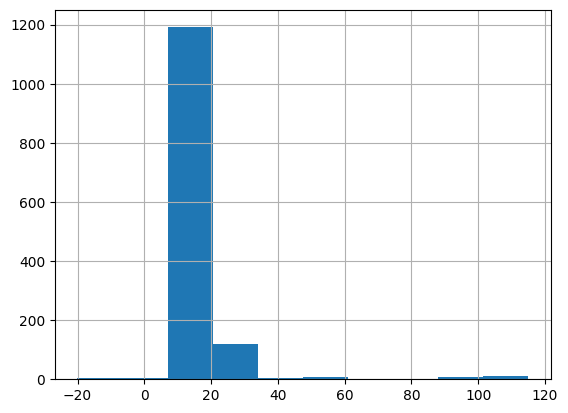

In [231]:
print("\n\n◉ HISTOGRAMA PARA VER APROXIMADAMENTE VALORES ATÍPICOS\n")
df["CVD Risk Score"].hist()

Con la anterior gráfica se pueden identificar los outliers de la variable CVD Risk Score, que es la variable objetivo. Se pueden observar algunos puntos muy alejados del resto de los datos, lo que indica que son valores atípicos. Para tratarlos, se puede utilizar el método del rango intercuartílico (IQR) para identificar y eliminar estos outliers del conjunto de datos. Esto ayudará a mejorar la calidad del modelo y a obtener resultados más precisos.

In [232]:
Q1 = df["CVD Risk Score"].quantile(0.05)
Q3 = df["CVD Risk Score"].quantile(0.95)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

df = df[(df["CVD Risk Score"] >= lower) & (df["CVD Risk Score"] <= upper)]

## División del conjunto de datos

Para evaluar adecuadamente la capacidad de generalización de los modelos, el dataset será dividido en Conjunto de entrenamiento (75%) y Conjunto de prueba (25%)

El conjunto de entrenamiento se utilizará para el ajuste de modelos y la búsqueda de hiperparámetros.

El conjunto de prueba se utilizará al final para evaluar el desempeño del modelo que seleccionems.

In [233]:
target = "CVD Risk Score"
X = df.drop(columns=[target])
y = df[target]

In [234]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Asi queda el tamaño de cada conjunto:

In [235]:
X_train.shape, y_train.shape

((985, 23), (985,))

In [236]:
X_test.shape, y_test.shape

((329, 23), (329,))

## 1. Modelo de regresión polinomial
La regresión polinomial permite modelar relaciones no lineales mediante la expansión de las variables originales en términos de mayor grado.

1. Preprocesamiento
2. Generación de características polinomiales
3. Modelo de regresión lineal

Con GridSearchCV para explorar los diferentes grados del polinomio y distintas estrategias de escalamiento

El desempeño será evaluado mediante los mismos parametros: RMSE, MAE y R²

## Pipeline

El pipeline es una herramienta que permite encadenar varias etapas de procesamiento y modelado en un flujo de trabajo coherente. En este caso, se utilizará para combinar el preprocesamiento de datos, la generación de características polinomiales y el modelo de regresión lineal en un solo objeto que se puede ajustar y evaluar de manera eficiente. Asi se aplicaran las mismas transformaciones tanto al conjunto de entrenamiento como al de prueba, evitando fugas de datos y asegurando una evaluación justa del modelo.

Ahora procedemos a eliminar las columnas irrelevantes, en este caso Patient ID, Date of Service, Blood Pressure, y Height (m), ya que tenemos una columna ya llamada Height (cm), por lo que es redundante, estas columnas  no aportan información relevante para el modelo de regresión polinomial y podrían introducir ruido en el proceso de modelado.

In [237]:
columnas_drop = ["Patient ID", "Date of Service", "Blood Pressure (mmHg)",
                 "Height (m)"]

def drop(df):
    return df.drop(columns=columnas_drop, errors="ignore")

dropper = FunctionTransformer(drop, validate=False)

Podemos ver que en el laboratorio anterior se observaron datos estadisticos del dataframe encontramos algunos datos que no son validos. Por ejemplo, el colesterol total tiene un min = - 1.256, pasaremos este valor a positivo con valor absoluto, por otra parte, el LDL estimado tiene min= -92.055. Haremos lo mismo, pondremos el absoluto de estos valores. Luego los utilizaremos en el pipeline.

In [238]:
def limpiar_colesterol(df):
    df["Total Cholesterol (mg/dL)"] = df["Total Cholesterol (mg/dL)"].abs()
    return df

def limpiar_ldl(df):
    df["Estimated LDL (mg/dL)"] = df["Estimated LDL (mg/dL)"].abs()
    return df

limpieza_colesterol = FunctionTransformer(limpiar_colesterol)
limpieza_ldl = FunctionTransformer(limpiar_ldl)


Ahora, podemos separar la columna blood pressure y reemplazar los datos de Systolic y Diastolic en las columnas correspondientes, donde estas esten vacias, esto con el fin de tener una mejor interpretación de los datos y evitar confusiones al momento de modelar. 

In [239]:
def separar_presion(df):
    df = df.copy()
    if "Blood Pressure (mmHg)" in df.columns:
        bp = df["Blood Pressure (mmHg)"].str.extract(r'(\d+)/(\d+)')
        
        df["Systolic BP"] = bp[0].astype(float)
        df["Diastolic BP"] = bp[1].astype(float)
    return df

separacion_presion = FunctionTransformer(separar_presion)


## Imputaciones con variables dependientes

En la siguiente gráfica se muestra un heatmap para visualizar la correlación entre las variables numéricas del dataset. Esto nos permite identificar qué variables tienen una relación más fuerte con la variable objetivo (CVD Risk Score) y cuáles podrían ser útiles para la imputación de valores faltantes en otras variables. Al observar el heatmap, podemos tomar decisiones informadas sobre cómo manejar los datos faltantes y mejorar la calidad del modelo.



◉ HEATMAP PARA VER CORRELACIÓN ENTRE VARIABLES:



<Axes: >

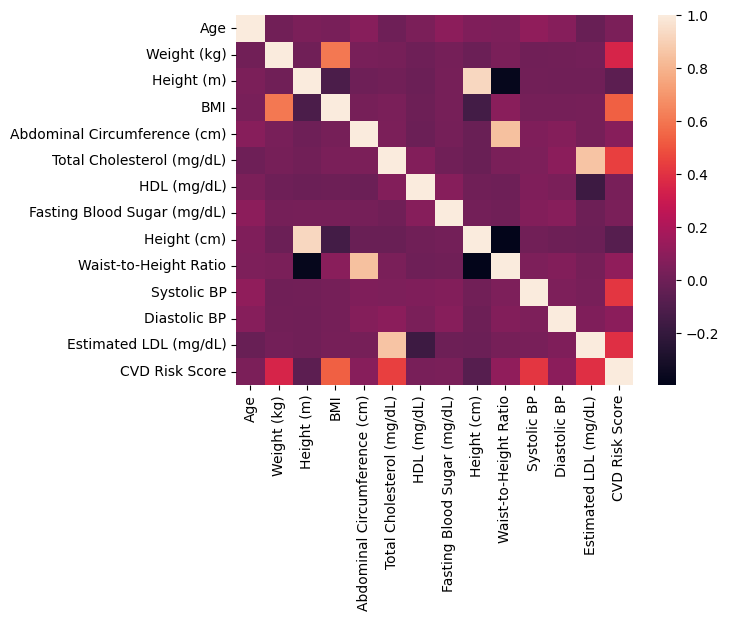

In [240]:
print("\n\n◉ HEATMAP PARA VER CORRELACIÓN ENTRE VARIABLES:\n")
sns.heatmap(df.corr(numeric_only=True))

Como podemos ver en la anterior gráfica, la variable Abdominal Circumference (cm) tiene una correlación importante con la variable Waist-toHeight Ratio, por lo que se puede utilizar esta última para imputar los valores faltantes de la primera. Lo mismo ocurre con Total Cholesterol (mg/dL) y Estimated LDL (mg/dL), que tienen una correlación significativa, por lo que se puede utilizar la variable Estimated LDL para imputar los valores faltantes de Total Cholesterol. Estas imputaciones basadas en variables dependientes pueden ayudar a mejorar la calidad del dataset y, por ende, el desempeño del modelo de regresión polinomial.

A continuación vamos a ver las columnas con valores nulos, para luego decidir cómo imputarlos. 

In [241]:
df.isna().sum().sort_values(ascending=False)

Date of Service                 1049
HDL (mg/dL)                       65
Waist-to-Height Ratio             62
Weight (kg)                       61
Diastolic BP                      58
Age                               57
Total Cholesterol (mg/dL)         55
Height (cm)                       55
Systolic BP                       53
Estimated LDL (mg/dL)             47
Height (m)                        46
Fasting Blood Sugar (mg/dL)       46
Abdominal Circumference (cm)      45
BMI                               42
Patient ID                         0
Sex                                0
Family History of CVD              0
Physical Activity Level            0
Diabetes Status                    0
Smoking Status                     0
Blood Pressure (mmHg)              0
Blood Pressure Category            0
CVD Risk Score                     0
CVD Risk Level                     0
dtype: int64

Por el heatmap notamos que la mayoria de los datos no están correlacionados excepto por Abdominal Circunference con Waist-to-Height Ratio y Total Cholesterol con Estimated LDL (mg/dL). Por lo que imputaremos los datos nulos de estas variables usando el método de varialbes correlacionadas.

In [242]:
def imputar_total_cholesterol_con_ldl(df):
    y = "Total Cholesterol (mg/dL)"
    x = "Estimated LDL (mg/dL)"
    
    k = (df[y] / df[x]).dropna().median()
    df = df.fillna({y: k * df[x]})
    df[y] = df[y].round()
    return df

chol_imputer = FunctionTransformer(imputar_total_cholesterol_con_ldl, validate=False)

In [243]:
def imputar_waist_to_height_ratio_con_circ(df):
    ratio = "Waist-to-Height Ratio"
    circ = "Abdominal Circumference (cm)"
    k = (df[ratio] / df[circ]).dropna().median()
    df = df.fillna({ratio: df[circ] * k})
    df[ratio] = df[ratio].round()
    return df

waist_height_imputer = FunctionTransformer(imputar_waist_to_height_ratio_con_circ, validate=False)



Ahora procedemos a separar las variables numéricas, ordinales y categóricas con el fin de aplicar las transformaciones necesarias para cada tipo de variable. 

In [244]:
numeric_features = [
    "Age", "Weight (kg)", "BMI", "Height (cm)",
    "Abdominal Circumference (cm)", "Total Cholesterol (mg/dL)",
    "HDL (mg/dL)", "Fasting Blood Sugar (mg/dL)",
    "Waist-to-Height Ratio", "Systolic BP", "Diastolic BP",
    "Estimated LDL (mg/dL)",
]


ordinal_features = ["Physical Activity Level", "Blood Pressure Category", 
                    "CVD Risk Level"]

categorical_features = [
    "Sex", "Smoking Status", "Diabetes Status",
    "Family History of CVD",
]

Ya que tenemos separadas las variables numéricas, ordinales y categóricas, podemos aplicar las transformaciones necesarias para cada tipo de variable. Vamos a solucionar problemas de completitud imputando por la media, escalaremos las variables numéricas con StandardScaler, y aplicaremos PolynomialFeatures() a las variables numéricas.

In [245]:
numeric_transformer_polinomial = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
        ("polynomial", PolynomialFeatures(degree=2)),
    ]
)

Hacemos las mismas transformaciones para las variables categóricas y ordinales que se hicieron en el laboratorio anterior.

In [246]:
categorical_transformer = Pipeline(
    steps= [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", drop="if_binary")),
    ]
)

In [247]:
ordinal_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        (
            "ordinal",
            OrdinalEncoder(
                categories= [
                    ["Low, Moderate, High"],
                    ["Normal", "Elevated", "Hypertension Stage 1", "Hypertension Stage 2"],
                    ["Low", "Moderate", "High"]
                ],
                handle_unknown="use_encoded_value",
                unknown_value= np.nan,
            ),
        ),
        ("imputer_after", SimpleImputer(strategy="most_frequent")),
    ]
)

Ahora con ColumnTransformer, combinamos las transformaciones para las variables numéricas, ordinales y categóricas en un solo objeto que se puede aplicar a los datos de entrenamiento y prueba. Esto nos permite asegurarnos de que todas las transformaciones se apliquen de manera consistente y eficiente durante el proceso de modelado.

In [248]:
preprocessor = ColumnTransformer(
    transformers= [
        ("num_scaled", numeric_transformer_polinomial, numeric_features),
        ("ord", ordinal_transformer, ordinal_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

Finalmente, definimos el pipeline completo que incluye el preprocesamiento de datos y el modelo de regresión lineal. Esto nos permitirá ajustar el modelo de manera eficiente y evaluar su desempeño utilizando las métricas RMSE, MAE y R².

In [249]:
pipeline_regresion_polinomial = Pipeline(
    steps=[
        ("separacion_presion", separacion_presion),
        ("dropper", dropper),
        ("limpiar_colesterol", limpieza_colesterol),
        ("limpiar_ldl", limpieza_ldl),
        ("imputacion_cholesterol", chol_imputer),
        ("imputacion_whtr", waist_height_imputer),
        ("preprocessor", preprocessor),
        ("modelo", LinearRegression()),
    ]
)

Visualizamos el pipeline de la regresión polinomial.

In [250]:
from sklearn import set_config
set_config(display="diagram")

pipeline_regresion_polinomial

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('separacion_presion', ...), ('dropper', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"func func: callable, default=NoneThe callable to use for the transformation. This will be passedthe same arguments as transform, with args and kwargs forwarded.If func is None, then func will be the identity function.",<function sep...001A8CEDB22A0>
,"inverse_func inverse_func: callable, default=NoneThe callable to use for the inverse transformation. This will bepassed the same arguments as inverse transform, with args andkwargs forwarded. If inverse_func is None, then inverse_funcwill be the identity function.",None
,"validate validate: bool, default=FalseIndicate that the input X array should be checked before calling``func``. The possibilities are:- If False, there is no input validation.- If True, then X will be converted to a 2-dimensional NumPy array or sparse matrix. If the conversion is not possible an exception is raised... versionchanged:: 0.22 The default of ``validate`` changed from True to False.",False
,"accept_sparse accept_sparse: bool, default=FalseIndicate that func accepts a sparse matrix as input. If validate isFalse, this has no effect. Otherwise, if accept_sparse is false,sparse matrix inputs will cause an exception to be raised.",False
,"check_inverse check_inverse: bool, default=TrueWhether to check that or ``func`` followed by ``inverse_func`` leads tothe original inputs. It can be used for a sanity check, raising awarning when the condition is not fulfilled... versionadded:: 0.20",True
,"feature_names_out feature_names_out: callable, 'one-to-one' or None, default=NoneDetermines the list of feature names that will be returned by the`get_feature_names_out` method. If it is 'one-to-one', then the outputfeature names will be equal to the input feature names. If it is acallable, then it must take two positional arguments: this`FunctionTransformer` (`self`) and an array-like of input feature names(`input_features`). It must return an array-like of output featurenames. The `get_feature_names_out` method is only defined if`feature_names_out` is not None.See ``get_feature_names_out`` for more details... versionadded:: 1.1",None
,"kw_args kw_args: dict, default=NoneDictionary of additional keyword argum

## Modelo de regresión polinomial de grado 2

In [251]:
pipeline_regresion_polinomial.fit(X_train, y_train)

c:\Users\jsrt3\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\impute\_base.py:641: UserWarning: Skipping features without any observed values: [0 2]. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('separacion_presion', ...), ('dropper', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"func func: callable, default=NoneThe callable to use for the transformation. This will be passedthe same arguments as transform, with args and kwargs forwarded.If func is None, then func will be the identity function.",<function sep...001A8CEDB22A0>
,"inverse_func inverse_func: callable, default=NoneThe callable to use for the inverse transformation. This will bepassed the same arguments as inverse transform, with args andkwargs forwarded. If inverse_func is None, then inverse_funcwill be the identity function.",None
,"validate validate: bool, default=FalseIndicate that the input X array should be checked before calling``func``. The possibilities are:- If False, there is no input validation.- If True, then X will be converted to a 2-dimensional NumPy array or sparse matrix. If the conversion is not possible an exception is raised... versionchanged:: 0.22 The default of ``validate`` changed from True to False.",False
,"accept_sparse accept_sparse: bool, default=FalseIndicate that func accepts a sparse matrix as input. If validate isFalse, this has no effect. Otherwise, if accept_sparse is false,sparse matrix inputs will cause an exception to be raised.",False
,"check_inverse check_inverse: bool, default=TrueWhether to check that or ``func`` followed by ``inverse_func`` leads tothe original inputs. It can be used for a sanity check, raising awarning when the condition is not fulfilled... versionadded:: 0.20",True
,"feature_names_out feature_names_out: callable, 'one-to-one' or None, default=NoneDetermines the list of feature names that will be returned by the`get_feature_names_out` method. If it is 'one-to-one', then the outputfeature names will be equal to the input feature names. If it is acallable, then it must take two positional arguments: this`FunctionTransformer` (`self`) and an array-like of input feature names(`input_features`). It must return an array-like of output featurenames. The `get_feature_names_out` method is only defined if`feature_names_out` is not None.See ``get_feature_names_out`` for more details... versionadded:: 1.1",None
,"kw_args kw_args: dict, default=NoneDictionary of additional keyword argum

El anterior pipeline va a ser utilizado para el conjunto de entrenamiento, para ajustar el modelo de regresión polinomial de grado 2. Luego, se evaluará el desempeño del modelo utilizando las métricas RMSE, MAE y R² en el conjunto de prueba para determinar su capacidad de generalización.

Podemos determinar el tamaño de del modelo visualizando el número de coeficientes del modelo de regresión polinomial de grado 2. Esto nos dará una idea de la complejidad del modelo y de cuántas características se están utilizando para hacer las predicciones. Un mayor número de coeficientes puede indicar un modelo más complejo, lo que podría llevar a un mejor ajuste a los datos de entrenamiento pero también a un mayor riesgo de sobreajuste. Por lo tanto, es importante evaluar el desempeño del modelo en el conjunto de prueba para asegurarnos de que generalice bien a nuevos datos.

In [252]:
modelo = pipeline_regresion_polinomial.named_steps["modelo"]
num_coeficientes = len(modelo.coef_)
print("Número de coeficientes:", num_coeficientes)

Número de coeficientes: 96


Ahora ya podemos ajustar el pipeline con las variables independientes y aplicar las operaciones que se definieron en el pipeline, y asi la regresion polinomial realice las predicciones correspondientes.

In [253]:
y_train_pred = pipeline_regresion_polinomial.predict(X_train)

c:\Users\jsrt3\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\impute\_base.py:641: UserWarning: Skipping features without any observed values: [0 2]. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


Luego validamos el modelo, analizando que tan alejadas están las predicciones del modelo con respecto a los valores reales utilizando las métricas RMSE, MAE y R². Esto nos permitirá evaluar la capacidad de generalización del modelo y determinar si es adecuado para hacer predicciones en nuevos datos.

In [254]:
print(f'------ Modelo de regresión polinomial grado 2 ----')
print(f"RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred)):.2f}")
print(f"MAE: {mean_absolute_error(y_train, y_train_pred):.2f}")
print(f"R²: {r2_score(y_train, y_train_pred):.4f}")

------ Modelo de regresión polinomial grado 2 ----
RMSE: 1.39
MAE: 0.57
R²: 0.7408


Podemos observar que el modelo de regresión polinomial de grado 2 tiene un desempeño mejor que el modelo de regresión lineal simple, lo que indica que la relación entre las variables numéricas y la variable objetivo no es lineal. Sin embargo, es importante evaluar si este modelo es el más adecuado para nuestros datos y si no está sobreajustando, lo cual se puede verificar mediante la comparación de las métricas en el conjunto de prueba.
Modelo regresión lineal:
| Métrica | Modelo 1 (train) | Modelo 2 (train) | Mejor en train |
|---|---:|---:|---|
| *MAE* | *0.4581174846673159* | 1.1640357102089873 | *Modelo 1* (menor) |
| *RMSE* | *1.3266849415195463* | 1.6476805007046733 | *Modelo 1* (menor) |
| *R²* | *0.7550437721603669* | 0.6221678667206385 | *Modelo 1* (mayor) |

Con las métricas del notebook, el Modelo lineal 1 (LAB 1, train) muestra un desempeño ligeramente mejor que el modelo polinomial grado 2 (LAB 2, train), ya que presenta menor MAE (≈ 0.458 vs. ≈ 0.57), menor RMSE (≈ 1.327 vs. ≈ 1.39) y mayor R² (≈ 0.755 vs. ≈ 0.741); sin embargo, esta comparación no es completamente equivalente porque entre LAB 1 y LAB 2 se cambió el tratamiento de outliers con IQR (en LAB 1 se usó cuantiles 0.05 y 0.90, mientras que en LAB 2 se usó 0.05 y 0.95), y al aumentar el cuantil superior de 0.90 a 0.95 el IQR se hace más grande, los límites de detección de outliers ([Q1 - 1.5IQR,; Q3 + 1.5IQR]) se vuelven más amplios, se eliminan menos registros y permanecen más valores extremos en el dataset, lo cual suele incrementar la variabilidad de la variable objetivo, hacer más difícil el problema y empeorar MAE/RMSE, incluso si el modelo es más flexible como el polinomial.


### Estimación de la capacidad de generalización del modelo

Ahora vamos a estimar la capacidad de generalización del modelo de regresión polinomial de grado 2 utilizando el conjunto de prueba. 

In [255]:
y_test_pred = pipeline_regresion_polinomial.predict(X_test)

c:\Users\jsrt3\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\impute\_base.py:641: UserWarning: Skipping features without any observed values: [0 2]. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


In [256]:
print(f'------ Modelo de regresión polinomial grado 2 - Resultados en test ----')
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred)):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_test_pred):.2f}")
print(f'R²: {r2_score(y_test, y_test_pred):.2f}')

------ Modelo de regresión polinomial grado 2 - Resultados en test ----
RMSE: 1.33
MAE: 0.58
R²: 0.76


Podemos ver que el modelo generaliza muy bien, tiene un mejor desempeño que el ajuste con los datos de entrenamiento, lo que indica que el modelo no está sobreajustando y es capaz de hacer predicciones precisas en nuevos datos. Esto sugiere que el modelo de regresión polinomial de grado 2 es adecuado.

## Modelo de regresión polinomial de grado 3

Cambiamos ahora el grado del polinomio a 3 para evaluar si un modelo más complejo puede mejorar el desempeño en el conjunto de entrenamiento y prueba. Esto nos permitirá comparar los resultados con el modelo de grado 2 y determinar si el aumento en la complejidad del modelo se traduce en una mejora significativa en las métricas de evaluación. Primero modificamos el pipeline:

In [257]:
numeric_transformer_polinomial_g3 = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
        ("polynomial", PolynomialFeatures(degree=3)),
    ]
)

In [258]:
preprocessor_g3 = ColumnTransformer(
    transformers= [
        ("num_scaled", numeric_transformer_polinomial_g3, numeric_features),
        ("ord", ordinal_transformer, ordinal_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [259]:
pipeline_regresion_polinomial_g3 = Pipeline(
    steps=[
        ("separacion_presion", separacion_presion),
        ("dropper", dropper),
        ("limpiar_colesterol", limpieza_colesterol),
        ("limpiar_ldl", limpieza_ldl),
        ("imputacion_cholesterol", chol_imputer),
        ("imputacion_whtr", waist_height_imputer),
        ("preprocessor", preprocessor_g3),
        ("modelo", LinearRegression()),
    ]
)

Ajustamos el pipeline con los datos de entrenamiento para el modelo de regresión polinomial de grado 3, aplicando las mismas transformaciones que se hicieron para el modelo de grado 2, pero ahora con un grado mayor en la generación de características polinomiales.

In [260]:
pipeline_regresion_polinomial_g3.fit(X_train, y_train)

c:\Users\jsrt3\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\impute\_base.py:641: UserWarning: Skipping features without any observed values: [0 2]. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('separacion_presion', ...), ('dropper', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"func func: callable, default=NoneThe callable to use for the transformation. This will be passedthe same arguments as transform, with args and kwargs forwarded.If func is None, then func will be the identity function.",<function sep...001A8CEDB22A0>
,"inverse_func inverse_func: callable, default=NoneThe callable to use for the inverse transformation. This will bepassed the same arguments as inverse transform, with args andkwargs forwarded. If inverse_func is None, then inverse_funcwill be the identity function.",None
,"validate validate: bool, default=FalseIndicate that the input X array should be checked before calling``func``. The possibilities are:- If False, there is no input validation.- If True, then X will be converted to a 2-dimensional NumPy array or sparse matrix. If the conversion is not possible an exception is raised... versionchanged:: 0.22 The default of ``validate`` changed from True to False.",False
,"accept_sparse accept_sparse: bool, default=FalseIndicate that func accepts a sparse matrix as input. If validate isFalse, this has no effect. Otherwise, if accept_sparse is false,sparse matrix inputs will cause an exception to be raised.",False
,"check_inverse check_inverse: bool, default=TrueWhether to check that or ``func`` followed by ``inverse_func`` leads tothe original inputs. It can be used for a sanity check, raising awarning when the condition is not fulfilled... versionadded:: 0.20",True
,"feature_names_out feature_names_out: callable, 'one-to-one' or None, default=NoneDetermines the list of feature names that will be returned by the`get_feature_names_out` method. If it is 'one-to-one', then the outputfeature names will be equal to the input feature names. If it is acallable, then it must take two positional arguments: this`FunctionTransformer` (`self`) and an array-like of input feature names(`input_features`). It must return an array-like of output featurenames. The `get_feature_names_out` method is only defined if`feature_names_out` is not None.See ``get_feature_names_out`` for more details... versionadded:: 1.1",None
,"kw_args kw_args: dict, default=NoneDictionary of additional keyword argum

Vemos ahora el tamaño del modelo de regresión polinomial de grado 3, visualizando el número de coeficientes del modelo. Esto nos dará una idea de la complejidad del modelo y de cuántas características se están utilizando para hacer las predicciones. Un mayor número de coeficientes puede indicar un modelo más complejo, lo que podría llevar a un mejor ajuste a los datos de entrenamiento pero también a un mayor riesgo de sobreajuste. 

In [261]:
modelo = pipeline_regresion_polinomial_g3.named_steps["modelo"]
num_coeficientes = len(modelo.coef_)
print("Número de coeficientes:", num_coeficientes)

Número de coeficientes: 460


Ahora, determinaremos el desempeño del modelo de regresión polinomial de grado 3 en el conjunto de prueba utilizando las métricas RMSE, MAE y R² para evaluar su capacidad de generalización. Esto nos permitirá comparar los resultados con el modelo de grado 2 y determinar si el aumento en la complejidad del modelo se traduce en una mejora significativa en las métricas de evaluación.

In [262]:
y_train_pred = pipeline_regresion_polinomial_g3.predict(X_train)
print(f'------ Modelo de regresión polinomial grado 3 ----')
print(f"RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred)):.2f}")
print(f"MAE: {mean_absolute_error(y_train, y_train_pred):.2f}")
print(f'R²: {r2_score(y_train, y_train_pred):.2f}')

------ Modelo de regresión polinomial grado 3 ----
RMSE: 1.00
MAE: 0.54
R²: 0.87


c:\Users\jsrt3\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\impute\_base.py:641: UserWarning: Skipping features without any observed values: [0 2]. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


In [263]:
y_test_pred = pipeline_regresion_polinomial_g3.predict(X_test)
print(f'------ Modelo de regresión polinomial grado 3 - Resultados en test ----')
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred)):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_test_pred):.2f}")
print(f'R²: {r2_score(y_test, y_test_pred):.2f}')

------ Modelo de regresión polinomial grado 3 - Resultados en test ----
RMSE: 5.29
MAE: 2.05
R²: -2.70


c:\Users\jsrt3\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\impute\_base.py:641: UserWarning: Skipping features without any observed values: [0 2]. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


En el conjunto de prueba vemos que el modelo de regresión polinomial de grado 3 tiene un desempeño peor que el modelo de grado 2, lo que indica que el aumento en la complejidad del modelo no se traduce en una mejora significativa en las métricas de evaluación. Esto sugiere que el modelo de regresión polinomial de grado 2 es más adecuado para nuestros datos y que el modelo de grado 3 podría estar sobreajustando a los datos de entrenamiento, lo que resulta en un peor desempeño en el conjunto de prueba. Hay una capacidad de generalización limitada en el modelo de grado 3, lo que indica que no es capaz de hacer predicciones precisas en nuevos datos, a pesar de su mayor complejidad. Esto refuerza la idea de que el modelo de regresión polinomial de grado 2 es más adecuado para nuestros datos.

## Búsqueda de hiperparámetros con GridSearchCV (validación cruzada)

Vamos a encontrar los mejores hiperparámetros para el modelo de regresión polinomial utilizando GridSearchCV con validación cruzada. Esto nos permitirá evaluar diferentes combinaciones de hiperparámetros y seleccionar la que proporcione el mejor desempeño en términos de las métricas de evaluación, como RMSE, MAE y R². Al realizar esta búsqueda, podremos optimizar el modelo y mejorar su capacidad de generalización a nuevos datos. La idea es entrenar múltiples modelos y retornar el de mejor desempeño.
Para esto definiremos el espacio de búsqueda de los hiperparámetros, en este caso las transformaciones van a ser de grado 1,2,3 y 4, también utilizaremos diferentes métodos de escaladado (StandardScaler, RobutScaler, MinMaxScaler) para evaluar cuál es el más adecuado para nuestros datos y modelo. Esto nos permitirá encontrar la combinación de hiperparámetros que optimice el desempeño del modelo de regresión polinomial.

In [264]:
param_grid = {
    "preprocessor__num_scaled__polynomial__degree": [1, 2, 3, 4],
    "preprocessor__num_scaled__scaler": [
        StandardScaler(),
        MinMaxScaler(),
        RobustScaler(),
    ],
}

Luego, vamos a utilizar GridSearchCV para realizar la búsqueda de hiperparámetros en el modelo de regresión polinomial. Esto nos permitirá evaluar diferentes combinaciones de hiperparámetros y seleccionar la que proporcione el mejor desempeño en términos de las métricas de evaluación, como RMSE, MAE y R². Al realizar esta búsqueda, podremos optimizar el modelo y mejorar su capacidad de generalización a nuevos datos. Se realizarán particiones mediante k-fold cross-validation, luego se promediaran los resultados obtenidos para asegurar una evaluación robusta de cada combinación de hiperparámetros.

In [265]:
grid_escalado = GridSearchCV(
    estimator=pipeline_regresion_polinomial, 
    param_grid = param_grid,
    cv = 5,
    scoring = "neg_root_mean_squared_error",
    n_jobs=-1,
    return_train_score=True
)

Ajustamos el grid al conjunto de entrenamiento.

In [266]:
%%time
grid_escalado.fit(X_train, y_train)


c:\Users\jsrt3\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\impute\_base.py:641: UserWarning: Skipping features without any observed values: [0 2]. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


CPU times: total: 297 ms
Wall time: 1.84 s


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...egression())])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'preprocessor__num_scaled__polynomial__degree': [1, 2, ...], 'preprocessor__num_scaled__scaler': [StandardScaler(), MinMaxScaler(), ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'neg_root_mean_squared_error'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the comp

Cuando ya se realiza la búsqueda de hiperparámetros con GridSearchCV, podemos analizar los resultados para identificar la combinación de hiperparámetros que proporciona el mejor desempeño en términos de las métricas de evaluación y capacidad de generalización en base a la validación cruzada.

In [267]:
print("Mejores hiperparámetros:")
print(grid_escalado.best_params_)
print(f"Mejor RMSE en validación cruzada: {-grid_escalado.best_score_:.2f}")

Mejores hiperparámetros:
{'preprocessor__num_scaled__polynomial__degree': 1, 'preprocessor__num_scaled__scaler': StandardScaler()}
Mejor RMSE en validación cruzada: 1.35


Recuperamos el mejor modelo y lo aplicamos al conjunto de test para evaluar su capacidad de generalización.

In [268]:
mejor_modelo = grid_escalado.best_estimator_

In [269]:
y_test_pred = mejor_modelo.predict(X_test)
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred)):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_test_pred):.2f}")
print(f'R²: {r2_score(y_test, y_test_pred):.2f}')

RMSE: 1.26
MAE: 0.44
R²: 0.79


c:\Users\jsrt3\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\impute\_base.py:641: UserWarning: Skipping features without any observed values: [0 2]. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


Finalmente, comparamos cada modelo con el RMSE de test y entrenamiento.

In [270]:
resultados_grid = pd.DataFrame(grid_escalado.cv_results_)

# Convertir score negativo a RMSE positivo
resultados_grid["mean_test_RMSE"] = -resultados_grid["mean_test_score"]
resultados_grid["mean_train_RMSE"] = -resultados_grid["mean_train_score"]

# Seleccionar columnas relevantes (deben coincidir con las claves del param_grid)
cols = [
    "param_preprocessor__num_scaled__polynomial__degree",
    "param_preprocessor__num_scaled__scaler",
    "mean_train_RMSE",
    "mean_test_RMSE",
    "std_test_score",
    "rank_test_score",
]

# Para que se vea mejor el nombre del scaler
resultados_grid["scaler_name"] = resultados_grid["param_preprocessor__num_scaled__scaler"].apply(lambda x: type(x).__name__)
cols_mostrar = [
    "param_preprocessor__num_scaled__polynomial__degree",
    "scaler_name",
    "mean_train_RMSE",
    "mean_test_RMSE",
    "rank_test_score",
]

resultados_grid[cols_mostrar].sort_values("rank_test_score").head(12)

,param_preprocessor__num_scaled__polynomial__degree,scaler_name,mean_train_RMSE,mean_test_RMSE,rank_test_score
0,1,StandardScaler,1.453298e+00,1.345391,1
1,1,MinMaxScaler,1.453298e+00,1.345391,2
2,1,RobustScaler,1.453298e+00,1.345391,2
4,2,MinMaxScaler,1.349337e+00,1.533868,4
5,2,RobustScaler,1.349337e+00,1.533883,5
3,2,StandardScaler,1.349337e+00,1.533883,6
11,4,RobustScaler,1.443340e-14,5.771974,7
9,4,StandardScaler,1.504068e-14,5.951607,8
10,4,MinMaxScaler,3.748655e-13,7.862997,9
6,3,StandardScaler,8.394812e-01,13.481516,10


Vemos las métricas del mejor modelo, que en este caso es de grado 1, con standard scaler, lo que indica que el modelo de regresión lineal simple con escalado estándar es el más adecuado para nuestros datos, ya que proporciona un mejor desempeño en términos de las métricas de evaluación y capacidad de generalización en base a la validación cruzada. Esto sugiere que la relación entre las variables numéricas y la variable objetivo es principalmente lineal, y que el escalado estándar ayuda a mejorar el desempeño del modelo.

In [271]:
mejor_modelo_escalado = grid_escalado.best_estimator_

y_test_pred = mejor_modelo_escalado.predict(X_test)

rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print("Desempeño en TEST del mejor modelo:")
print(f"RMSE: {rmse_test:.4f}")
print(f"MAE : {mae_test:.4f}")
print(f"R²  : {r2_test:.4f}")

Desempeño en TEST del mejor modelo:
RMSE: 1.2578
MAE : 0.4419
R²  : 0.7908


c:\Users\jsrt3\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\impute\_base.py:641: UserWarning: Skipping features without any observed values: [0 2]. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


Ahora calculamos el MSE promedio, la desviación estándar del MSE y el intervalo de confianza aproximado.

In [272]:
# Usamos 'neg_mean_squared_error' porque sklearn busca maximizar puntajes
# Lo multiplicamos por -1 para tener el MSE real
scores = cross_val_score(mejor_modelo, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
mse_scores = -scores

print(f"MSE promedio: {mse_scores.mean():.4f}")
print(f"Desviación Estándar del MSE: {mse_scores.std():.4f}")
print(f"Intervalo de confianza (aprox): [{mse_scores.mean() - 2*mse_scores.std():.4f}, {mse_scores.mean() + 2*mse_scores.std():.4f}]")

c:\Users\jsrt3\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\impute\_base.py:641: UserWarning: Skipping features without any observed values: [0 2]. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
c:\Users\jsrt3\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\impute\_base.py:641: UserWarning: Skipping features without any observed values: [0 2]. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
c:\Users\jsrt3\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\impute\_base.py:641: UserWarning: Skipping features without any observed values: [0 2]. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
c:\Users\jsrt3\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\impute\_base.py:641: UserWarning: Skipping features without any observed values: [0 2]. At least one

MSE promedio: 2.2494
Desviación Estándar del MSE: 2.1163
Intervalo de confianza (aprox): [-1.9833, 6.4821]


c:\Users\jsrt3\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\impute\_base.py:641: UserWarning: Skipping features without any observed values: [0 2]. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


## 2. Curvas de validación
Para analizar el impacto de la complejidad, se generarán curvas de validación que muestren cómo varía el error en función del grado del polinomio.
Se grafica el rrror promedio en validación cruzada y la desviación estándar del error
El objetivo es identificarel puunto de mínima generalización, la evidencia de sobreajuste y la relación entre complejidad y estabilidad,


## 3. Modelos de regresión regularizados

La regularización son para controlar la magnitud de los coeficientes y reducir el sobreajuste.
Se usaran las tecnicas Ridge y Lasso

Se utilizará GridSearchCV para buscar diferentes valores del parámetro de penalización y estrategias de escalamiento

El análisis incluirá:
- Comparación de métricas
- Evaluación de estabilidad
- Análisis de magnitud de coeficientes
- Identificación de variables eliminadas por Lasso

## 4. Modelo polinomial regularizado

En esta sección se hara la generación de características polinomiales y la regularización.
Se explorarán simultáneamente los grados del polinomio, los parámetro de penalización y una estrategia para escalar.
El objetivo es evaluar si la regularización permite controlar el sobreajuste generado por el aumento en la complejidad.

## 5. Comparación y selección del mejor modelo

Haremos una tabla comparando: RMSE, MAE y R² y basados en los datos explicaremos cual es el mejor modelo.

## 6. Construcción de ntervalos de confianza


## 7. Análisis de resultados

### Análisis cuantitativo:

- ¿Cuál modelo obtuvo el mejor desempeño en test?
- ¿Coincide con el mejor promedio en validación cruzada?
- ¿El modelo con mejor promedio es necesariamente el más adecuado?
- ¿Cómo cambia el error con la complejidad?
- ¿Cómo afecta la regularización la estabilidad de los coeficientes?
- ¿Los intervalos de confianza sugieren estabilidad o alta variabilidad?

### Análisis cualitativo:

- Variables seleccionadas por Lasso.
- Interpretación práctica de los coeficientes.
- Diferencias entre precisión e interpretabilidad.
- Implicaciones estratégicas para AlpesHearth.
- Si mayor complejidad implica mayor valor organizacional.

## 8. Reflexión conceptual

## 9. Uso de IA generativa

Durante el desarrollo del laboratorio usamos modelos de IA generativa como herramienta de apoyo conceptual y para la estructuración del notebook.

Las decisiones de modificacion de datos y construccion de modelps, la interpretación de los resultados y los analisis fueron realizadas por el equipo, unicamente usando inteligencia artificial para confirmar conceptos o estructurar adecuadamente elementos repetitivos en los bloques de codigo para ahorrar tiempo.